In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import cufflinks as cf
import pathlib
import pandas_profiling
import statsmodels.api as sm

In [7]:
#We set the all charts as public
cf.set_config_file(sharing='public',theme='pearl',offline=False)
cf.go_offline()

cwd = pathlib.Path.cwd()

# Regression

In [7]:

data = pd.read_csv(cwd/'mpg_dataset'/'auto-mpg.csv')

data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
report = data.profile_report()
report.to_file(output_file="auto-mpg.html")

In [8]:
#Dropping car_name
data.drop('car name', axis=1, inplace=True)
data.loc[data.horsepower=='?','horsepower'] = np.nan
data['horsepower'] = data.horsepower.astype(float, errors = 'raise')
data['horsepower']= data['horsepower'].fillna(data['horsepower'].mean())
data.dropna(inplace=True)

## Statsmodels Regression

In [9]:
X = data.drop(['mpg'], axis=1)
y = data['mpg']

In [10]:
## let's add an intercept (beta_0) to our model because Statsmodels does not do that by default
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/home/manujosephv/anaconda3/envs/blog/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     255.4
Date:                Tue, 12 Nov 2019   Prob (F-statistic):          2.25e-141
Time:                        21:45:07   Log-Likelihood:                -1040.3
No. Observations:                 398   AIC:                             2097.
Df Residuals:                     390   BIC:                             2129.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -18.0587      4.583     -3.940      0.000     -27.069      -9.048
cylinders       -0.4183      0.322     -1.299      0.195      -1.051       0.215
displacement     0.0189      0.008      2.518      0.012       0.004       0.034
horsepower      -0.0114      0.013     -0.865      0.388      -0.037       0.015
weight          -0.0067      0.001    -10.480      0.000      -0.008      -0.005
acceleration     0.1026      0.096      1.067      0.287      -0.086       0.292
model year       0.7568      0.050     15.008      0.000       0.658       0.856
origin           1.4175      0.275      5.154      0.000       0.877       1.958
==============================================================================
Omnibus:                       30.551   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.230
Skew:                           0.515   Prob(JB):                     2.04e-11
Kurtosis:                       4.381   Cond. No.                     8.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
model.params[1:].round(4).iplot(kind='bar')

In [18]:
#Standardizing the Regression coefficients
std_coeff = model.params
for col in X.columns:
    std_coeff[col] = (std_coeff[col]* np.std(X[col]))/ np.std(y)

In [19]:
std_coeff[1:].round(4).iplot(kind='bar')

## Sci-kit Learn

In [42]:
lm = LinearRegression()
lm.fit(X,y)
r2 = lm.score(X,y)
adj_r2 = 1-(1-r2)*(len(X)-1)/(len(X)-len(X.columns)-1)
print ("R2 Score: {:.2f}% | Adj R2 Score: {:.2f}%".format(r2*100,adj_r2*100))
params = pd.Series({'const': lm.intercept_})
for i,col in enumerate(X.columns):
    params[col] = lm.coef_[i]

R2 Score: 82.09% | Adj R2 Score: 81.72%


In [43]:
lr_params = params.copy()

In [110]:
params[1:].iplot(kind='bar')

**Getting exactly the same results as Stats Models**

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
lm = LinearRegression()
lm.fit(X_std,y)
r2 = lm.score(X_std,y)
adj_r2 = 1-(1-r2)*(len(X)-1)/(len(X)-len(X.columns)-1)
print ("R2 Score: {:.2f}% | Adj R2 Score: {:.2f}%".format(r2*100,adj_r2*100))
params = pd.Series({'const': lm.intercept_})
for i,col in enumerate(X.columns):
    params[col] = lm.coef_[i]

R2 Score: 82.09% | Adj R2 Score: 81.72%


In [22]:
params[1:].round(4).iplot(kind='bar')

## Ridge Regression

In [44]:
lm = RidgeCV()
lm.fit(X,y)
r2 = lm.score(X,y)
adj_r2 = 1-(1-r2)*(len(X)-1)/(len(X)-len(X.columns)-1)
print ("R2 Score: {:.2f}% | Adj R2 Score: {:.2f}%".format(r2*100,adj_r2*100))
params = pd.Series({'const': lm.intercept_})
for i,col in enumerate(X.columns):
    params[col] = lm.coef_[i]

R2 Score: 82.08% | Adj R2 Score: 81.72%


In [45]:
ridge_params = params.copy()

## Lasso

In [46]:
lm = LassoCV()
lm.fit(X,y)
r2 = lm.score(X,y)
adj_r2 = 1-(1-r2)*(len(X)-1)/(len(X)-len(X.columns)-1)
print ("R2 Score: {:.2f}% | Adj R2 Score: {:.2f}%".format(r2*100,adj_r2*100))
params = pd.Series({'const': lm.intercept_})
for i,col in enumerate(X.columns):
    params[col] = lm.coef_[i]

R2 Score: 76.67% | Adj R2 Score: 76.19%


/home/manujosephv/anaconda3/envs/blog/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [47]:
lasso_params = params.copy()

In [50]:
comparison_df = ridge_params.to_frame().join(lasso_params.to_frame(), lsuffix='_ridge', rsuffix='_lasso').join(lr_params.to_frame())

In [51]:
comparison_df.columns = ['ridge_coefficients','lasso_coefficients','original_coefficients']

In [57]:
comparison_df.style.format({
    'ridge_coefficients': '{:,.4f}'.format,
    'lasso_coefficients': '{:,.4f}'.format,
    'original_coefficients': '{:,.4f}'.format,
})

,ridge_coefficients,lasso_coefficients,original_coefficients
const,0.0000,0.0000,0.0000
cylinders,-0.3733,-0.0000,-0.4183
displacement,0.0176,-0.0036,0.0189
horsepower,-0.0105,-0.0108,-0.0114
weight,-0.0067,-0.0065,-0.0067
acceleration,0.1013,0.0000,0.1026
model year,0.7552,0.2852,0.7568
origin,1.3245,0.0000,1.4175


# Classification

In [6]:
from dtreeviz.trees import *

In [40]:
iris = pd.read_csv(cwd/"iris_dataset"/"Iris.csv")

iris.drop('Id',axis=1,inplace=True)

target_map = {'Iris-setosa':0, 
              'Iris-versicolor':1,
              'Iris-virginica':2 }
# Use the pandas apply method to numerically encode our attrition target variable
iris['Species'] = iris['Species'].apply(lambda x: target_map[x])

In [44]:
X = iris.iloc[:, :-1]  # Take only the first two features.
               
y = iris.Species

In [45]:
clf = DecisionTreeClassifier(min_samples_split = 4)
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [57]:
clf.score(X,y)

0.9866666666666667

In [48]:
feat_imp = pd.DataFrame({'features': X.columns.tolist(), "mean_decrease_impurity": clf.feature_importances_}).sort_values('mean_decrease_impurity', ascending=False)
feat_imp = feat_imp.head(25)
feat_imp.iplot(kind='bar',
               y='mean_decrease_impurity',
               x='features',
               yTitle='Mean Decrease Impurity',
               xTitle='Features',
               title='Mean Decrease Impurity',
              )

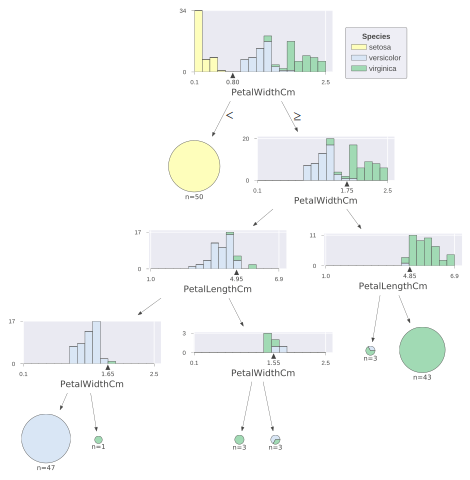

In [46]:
viz = dtreeviz(clf,
               X,
               y,
               target_name='Species',
               class_names=["setosa", "versicolor", "virginica"],
               feature_names=X.columns)
viz              

In [47]:
viz.save('dtree_viz_iris.svg')

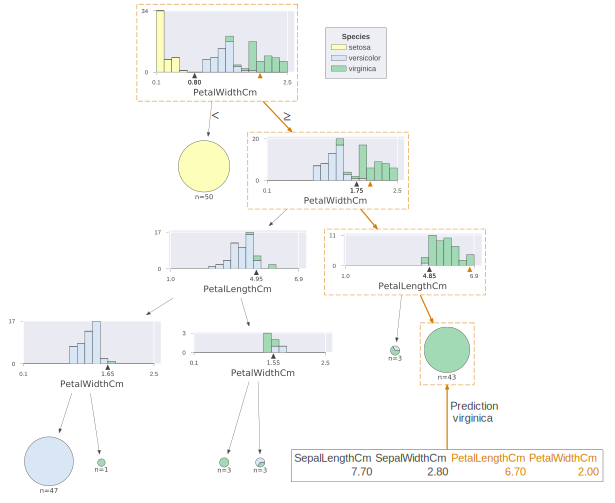

In [55]:
x = X.iloc[np.random.randint(0, len(X)),:]  # random sample from training
viz = dtreeviz(clf,
               X,
               y,
               target_name='Species',
               class_names=["setosa", "versicolor", "virginica"],
               feature_names=X.columns,
              X=x)
viz              

In [56]:
viz.save('dtree_viz_iris_pred_path.svg')

## Running with reduced features

In [58]:
X = iris.iloc[:, 2:-1]  # Take only the first two features.
               
y = iris.Species

In [60]:
clf = DecisionTreeClassifier(min_samples_split = 4)
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [61]:
clf.score(X,y)

0.9866666666666667